# 台灣銀行牌告匯率爬蟲練習
## 範例1： 練習爬取台幣對其他貨幣匯率資料

In [ ]:
import requests
from bs4 import BeautifulSoup
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

### 進入台灣銀行牌告匯率網頁：https://rate.bot.com.tw/xrt?Lang=zh-TW ，擷取當日台幣對美金的匯率資訊

In [ ]:
# 進入台灣銀行牌告匯率網頁，查看當日匯率資料
url = "https://rate.bot.com.tw/xrt?Lang=zh-TW"
resp = requests.get(url)
resp.encoding = 'utf-8'
# print(resp.text)  # 如有需要，列印出網頁原始碼

html = BeautifulSoup(resp.text, "lxml")
rate_table = html.find(name='table', attrs={'title':'牌告匯率'}).find(name='tbody').find_all(name='tr')

# 查詢美金(也就是匯率表的第一個元素)對台幣的匯率
currency = rate_table[0].find(name='div', attrs={'class':'visible-phone print_hide'})
print(currency.get_text().replace(" ", ""))  # 去掉空白

buy_rate = rate_table[0].find(name='td', attrs={'data-table':'本行現金買入'})
sell_rate = rate_table[0].find(name='td', attrs={'data-table':'本行現金賣出'})
print("即時現金買入: %s, 即時現金賣出: %s" % (buy_rate.get_text(), sell_rate.get_text()))

### 作業part 1：請參考上面的範例，試著爬取所有貨幣對台幣的匯率

In [ ]:
import requests
from bs4 import BeautifulSoup
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt


url = 'https://rate.bot.com.tw/xrt?Lang=zh-TW'
res = requests.get(url)
res.encoding ='utf-8'

html = BeautifulSoup(res.text,'lxml')
rate_table = html.find(name='table',attrs={'title':'牌告匯率'}).find(name='tbody').find_all(name='tr')

print("共有"+str(len(rate_table))+"種貨幣")

for i in range(0,19):
    #查詢美金
    currency = rate_table[i].find(name='div',attrs={'class':'hidden-phone print_show'})
    print(currency.text.replace(" ",""))

    buy_rate = rate_table[i].find(name='td',attrs={'data-table':'本行現金買入'})
    sell_rate = rate_table[i].find(name='td',attrs={'data-table':'本行現金賣出'})
    print('即時現金買入:%s,即時現金賣出:%s' % (buy_rate.text,sell_rate.text))



# #查詢美金
# currency = rate_table[0].find(name='div',attrs={'class':'hidden-phone print_show'})
# print(currency.text.replace(" ",""))

# buy_rate = rate_table[0].find(name='td',attrs={'data-table':'本行現金買入'})
# sell_rate = rate_table[0].find(name='td',attrs={'data-table':'本行現金賣出'})
# print('即時現金買入:%s,即時現金賣出:%s' % (buy_rate.text,sell_rate.text))



## 範例2：爬取一個月的美金對台幣歷史匯率資料，並畫出趨勢圖

In [71]:
# 先到牌告匯率首頁，爬取所有貨幣的種類
url = "https://rate.bot.com.tw/xrt?Lang=zh-TW"
resp = requests.get(url)
resp.encoding = 'utf-8'
html = BeautifulSoup(resp.text, "lxml")
rate_table = html.find(name='table', attrs={'title':'牌告匯率'}).find(name='tbody').find_all(name='tr')

# 擷取匯率表格，把美金(也就是匯率表的第一個元素)擷取出來，查詢其歷史匯率
currency = rate_table[0].find(name='div', attrs={'class':'visible-phone print_hide'})
print(currency.get_text().replace(" ", ""))  # 貨幣種類

# 針對美金，找到其「歷史匯率」的首頁 
history_link = rate_table[0].find(name='td', attrs={'data-table':'歷史匯率'})
history_rate_link = "https://rate.bot.com.tw" + history_link.a["href"]  # 該貨幣的歷史資料首頁

#
# 到貨幣歷史匯率網頁，選則該貨幣的「歷史區間」，送出查詢後，觀察其網址變化情形，再試著抓取其歷史匯率資料
#
# 用「quote/年-月」去取代網址內容，就可以連到該貨幣的歷史資料
quote_history_url = history_rate_link.replace("history", "quote/2019-08")
resp = requests.get(quote_history_url)
resp.encoding = 'utf-8'
history = BeautifulSoup(resp.text, "lxml")
history_table = history.find(name='table', attrs={'title':'歷史本行營業時間牌告匯率'}).find(name='tbody').find_all(name='tr')

#
# 擷取到歷史匯率資料後，把資料彙整起來並畫出趨勢圖
#
date_history = list()
history_buy = list()
history_sell = list()

for history_rate in history_table:
    # 擷取日期資料
    date_string = history_rate.a.get_text()
    date = datetime.strptime(date_string, '%Y/%M/%d').strftime('%Y/%M/%d')  # 轉換日期格式
    date_history.append(date)  # 日期歷史資料

    history_ex_rate = history_rate.find_all(name='td', attrs={'class':'rate-content-cash text-right print_table-cell'})
    history_buy.append(float(history_ex_rate[0].get_text()))  # 歷史買入匯率
    history_sell.append(float(history_ex_rate[1].get_text()))  # 歷史賣出匯率

# 將匯率資料建成dataframe形式
HistoryExchangeRate = pd.DataFrame({'date': date_history,
                                    'buy_rate':history_buy,
                                    'sell_rate':history_sell})

HistoryExchangeRate = HistoryExchangeRate.set_index('date')  # 指定日期欄位為datafram的index
HistoryExchangeRate = HistoryExchangeRate.sort_index(ascending=True)

# 畫出歷史匯率軌跡圖
plt.figure(figsize=(10, 8))
HistoryExchangeRate[['buy_rate','sell_rate']].plot()  # x=['date'], y=[['buy_rate','sell_rate']] 
plt.legend(loc="upper left")
plt.show()


美金(USD)



AttributeError: 'NoneType' object has no attribute 'get_text'

### 作業part 2：爬取每種貨幣對台幣的一個月歷史匯率資料，並畫出趨勢圖


美金(USD)



<Figure size 720x576 with 0 Axes>

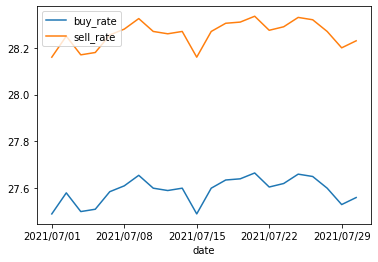


港幣(HKD)



<Figure size 720x576 with 0 Axes>

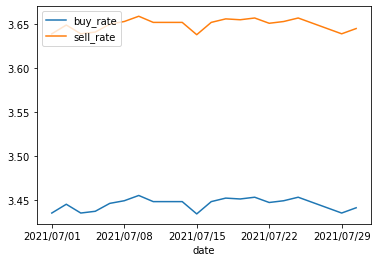


英鎊(GBP)



<Figure size 720x576 with 0 Axes>

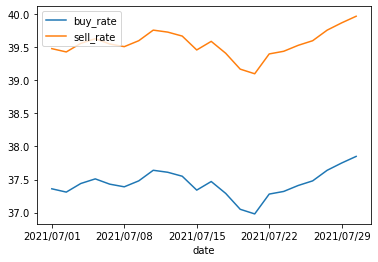


澳幣(AUD)



<Figure size 720x576 with 0 Axes>

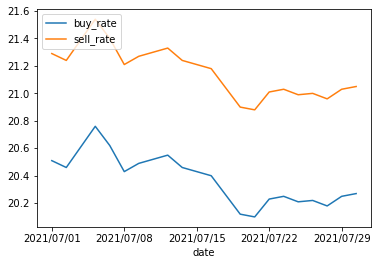


加拿大幣(CAD)



<Figure size 720x576 with 0 Axes>

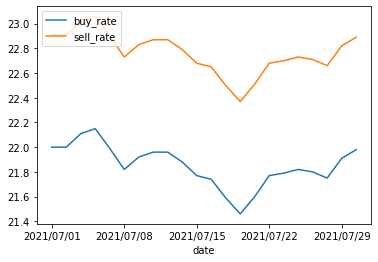


新加坡幣(SGD)



<Figure size 720x576 with 0 Axes>

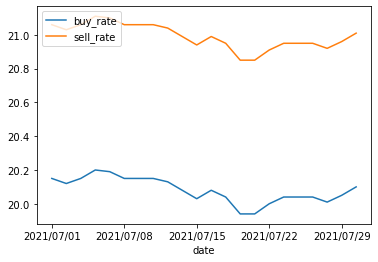


瑞士法郎(CHF)



<Figure size 720x576 with 0 Axes>

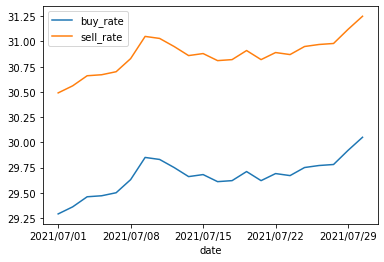


日圓(JPY)



<Figure size 720x576 with 0 Axes>

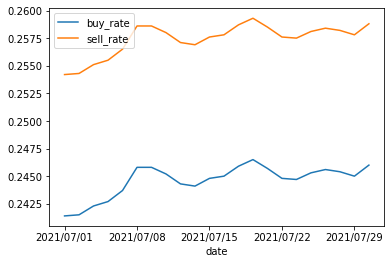


南非幣(ZAR)



<Figure size 720x576 with 0 Axes>

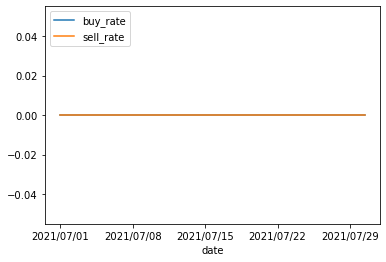


瑞典幣(SEK)



<Figure size 720x576 with 0 Axes>

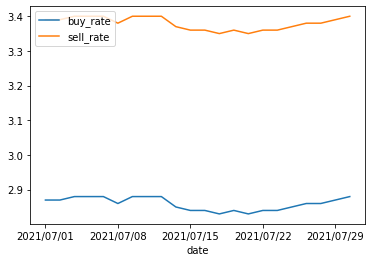


紐元(NZD)



<Figure size 720x576 with 0 Axes>

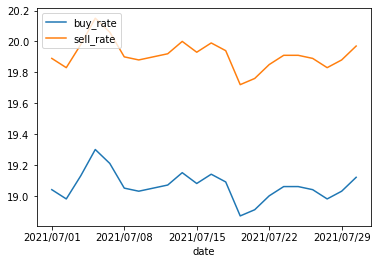


泰幣(THB)



<Figure size 720x576 with 0 Axes>

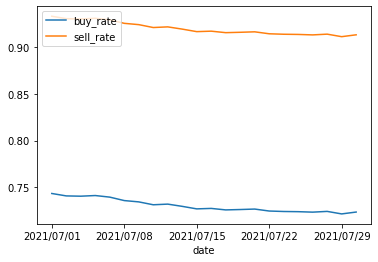


菲國比索(PHP)



<Figure size 720x576 with 0 Axes>

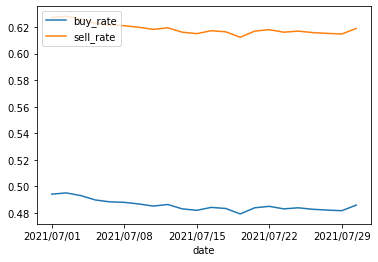


印尼幣(IDR)



<Figure size 720x576 with 0 Axes>

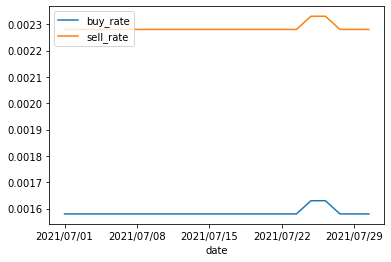


歐元(EUR)



<Figure size 720x576 with 0 Axes>

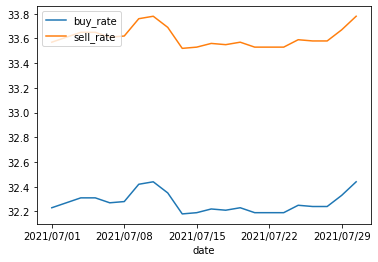


韓元(KRW)



<Figure size 720x576 with 0 Axes>

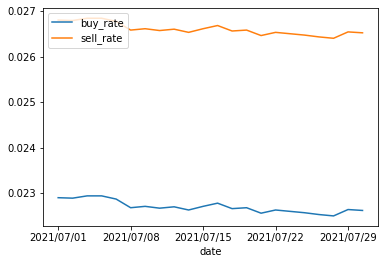


越南盾(VND)



<Figure size 720x576 with 0 Axes>

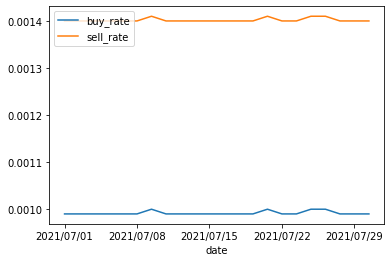


馬來幣(MYR)



<Figure size 720x576 with 0 Axes>

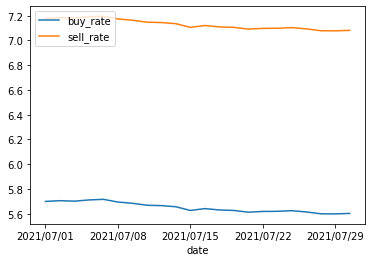


人民幣(CNY)



<Figure size 720x576 with 0 Axes>

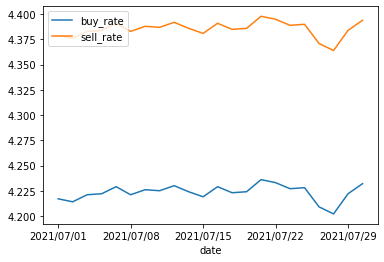

In [72]:
for i in range(0,19):
    url = 'https://rate.bot.com.tw/xrt?Lang=zh-TW'
    res = requests.get(url)
    html = BeautifulSoup(res.text,'lxml')
    rate_table = html.find(name='table',attrs={'title':'牌告匯率'}).find(name='tbody').find_all(name='tr')
    currency = rate_table[i].find(name='div',attrs={'class':'visible-phone print_hide'})
    print(currency.text.replace(" ",''))

    history_link =  rate_table[i].find(name='td',attrs={'data-table':'歷史匯率'})
    history_rate_link = 'https://rate.bot.com.tw/'+history_link.a['href']
    quote_link_url = history_rate_link.replace('history','quote/2021-07')
    res = requests.get(quote_link_url)
    res.encoding="utf-8"
    history = BeautifulSoup(res.text,'lxml')
    history_table = history.find(name='table',attrs={'title':'歷史本行營業時間牌告匯率'}).find(name='tbody').find_all(name='tr')
    history_table


    date_history = list()
    history_buy = list()
    history_sell = list()

    for history_rate in history_table:
        date_string = history_rate.a.text
        date = datetime.strptime(date_string,'%Y/%M/%d').strftime('%Y/%M/%d')
        date_history.append(date)

        history_ex_rate = history_rate.find_all(name="td",attrs={'class':'rate-content-cash text-right print_table-cell'})
        history_buy.append(float(history_ex_rate[0].text))
        history_sell.append(float(history_ex_rate[1].text))

    HistoryExchangeRate = pd.DataFrame({
        'date':date_history,
        'buy_rate':history_buy,
        'sell_rate':history_sell
    })

    HistoryExchangeRate = HistoryExchangeRate.set_index('date')
    HistoryExchangeRate = HistoryExchangeRate.sort_index(ascending = True)

    plt.figure(figsize=(10,8))
    HistoryExchangeRate[['buy_rate','sell_rate']].plot()
    plt.legend(loc="upper left")
    plt.show()
